In [ ]:
# %run common_imports.py
import seaborn as sns
%matplotlib qt
%config InlineBackend.figure_format = 'retina'
sns.set_context("talk")

%reload_ext autoreload
%autoreload 2
pd.options.display.max_rows = 600
pd.set_option('display.float_format', lambda x: '%.9f' % x)

dj.config['display.limit'] = 10**3  

os.environ["SPYGLASS_USE_TRANSACTIONS"] = "1"  
os.environ['KACHERY_API_KEY'] = "RhysjLwgmBAt2ObCyXXaDnqAv2kTdYRa"

import sys
import tuning_analysis.sorting_multiprocessing as smp
import spyglass.spikesorting.v1 as sgs
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.core as sc
import spyglass.position.v1 as sgp
import spyglass.linearization.v1 as sgpl

from spyglass.position import PositionOutput
from spyglass.spikesorting.analysis.v1.group import UnitSelectionParams
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup
from tuning_analysis.trial_extraction import *
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput
from tuning_analysis.spike_analysis import *
from pathlib import Path


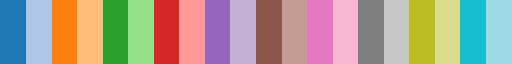

In [79]:
from cycler import cycler
cmap = 'tab20'
n_colors = 6
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0,1,n_colors)]
plt.rcParams["axes.prop_cycle"] = cycler(color = colors)
cmap

In [80]:
graph = sgpl.TrackGraph() & {"track_graph_name":"Wtrack_wilbur20210512"}

[2025-12-28 15:26:57,106][WARNING]: MySQL server has gone away. Reconnecting to the server.


### Plot unit-wise spiking locations

#### Fetch spikes

In [5]:
sorter_keys = {
    "nwb_file_name": nwb_copy_file_name,
    "sorter": "mountainsort4",
    "curation_id": 2,
}

pfc_merge_ids = SpikeSortingOutput().get_restricted_merge_ids(sorter_keys, restrict_by_artifact = True)

keys = [{"merge_id": merge_id} for merge_id in pfc_merge_ids]
(SpikeSortingOutput.CurationV1 & keys)

[12:17:59][WARNING] Spyglass: V0 requires artifact restrict. Ignoring "restrict_by_artifact" flag.


merge_id,sorting_id,curation_id
047f4da5-c1d4-ca9e-f923-cdb63c0d04e7,d14d9669-4f3e-47c8-bed9-e0cc90be7a71,2
0a29f32c-7036-e6bb-fd45-dc7ac35137fe,45539c29-3436-4633-b63d-f499fe8e4073,2
1a818a97-6f62-8d75-565f-7be81c6961c3,ee34cd1e-e742-4c73-bdae-9974c2b1d74a,2
3b2a05fa-9642-5ef4-58d7-1f8e9bf3e217,76904362-d49e-4883-98d1-442822ebb9a1,2
4db00acd-003c-de9a-b640-fb78fb276985,df857aaa-ccd8-4abf-82e2-e9b97706c162,2
6e499686-18c3-ef61-e344-d4e7d7c5e773,bae249c1-f797-4e38-83ee-a21f51684a20,2
70ca787c-23b6-feb6-84af-6e3ba338fdf3,1dd1e911-c185-4488-b607-83502ac5225f,2
d4644925-b88e-850f-36a2-291d1e1b99f7,48a2c037-f872-4a63-9ccb-1bd14cb727e4,2
e7eb99a4-da0e-a1ca-3be6-36e6037f9275,6868b312-14db-473b-ae34-ce1bd193055d,2
e9df24a9-9413-0623-2987-3064c50394ed,0c0d6f10-5af6-4add-beac-67f101ecb017,2


In [6]:
# get spikes from a specific group
group_key = {
    "nwb_file_name": nwb_copy_file_name,
    "sorted_spikes_group_name": "left mPFC",
}

SortedSpikesGroup().Units & group_key
group_key = (SortedSpikesGroup & group_key).fetch1("KEY")

l_mpfc_spikes = SortedSpikesGroup().fetch_spike_data(group_key)


#### Fetch position

In [ ]:
epoch = 2
dlc_centroid_params_name = "four_paw_centroid"
pos_key = {
    "nwb_file_name": nwb_copy_file_name,
    "epoch": f"{epoch}", 
    "dlc_model_params_name": "WtrackSep5",
    "dlc_centroid_params_name": dlc_centroid_params_name  
}

merge_id = (PositionOutput.DLCPosV1() & pos_key).fetch1("merge_id")

#### Plot

In [8]:
centroid_position = (PositionOutput() & {"merge_id": merge_id}).fetch1_dataframe()

In [107]:
# Single unit firing across all positions
unit = 4
spike_times = l_mpfc_spikes[unit]
spike_times = spike_times
spike_times = pd.Series([spike_time if spike_time < centroid_position.index[-1] else np.nan for spike_time in spike_times]).dropna().to_list()
spike_positions = np.searchsorted(centroid_position.index.tolist(), spike_times)
fig,ax = plt.subplots(layout = "tight")
ax.scatter(centroid_position.position_x, centroid_position.position_y, s = 4, color = 'k', alpha = 0.03)
ax.scatter(centroid_position.position_x.iloc[spike_positions], centroid_position.position_y.iloc[spike_positions], color = "#1188d8", s = 4, label = "spikes")
plt.legend();

### Extract trials

In [81]:
def get_centroid_and_linear_position(epoch: int,
                                     dlc_si_cohort_centroid: str = "four_paw_centroid_gap_15cm",
                                     linearization_param_name: str = "default"):
    merge_id = (PositionOutput.DLCPosV1() & {"epoch": epoch, "dlc_si_cohort_centroid": dlc_si_cohort_centroid}).fetch1("merge_id")
    centroid_df = (PositionOutput & {"merge_id": merge_id}).fetch1_dataframe()
    
    pos_merge_id = (PositionOutput.DLCPosV1() & {"dlc_si_cohort_centroid": dlc_si_cohort_centroid, "epoch": epoch}).fetch1("merge_id")
    linear_df =(sgpl.LinearizedPositionV1() & {"pos_merge_id":pos_merge_id, "linearization_param_name": linearization_param_name}).fetch1_dataframe()
    
    return centroid_df, linear_df

In [84]:
epoch2_centroid_df, epoch2_linear_df = get_centroid_and_linear_position(epoch=2,)
epoch4_centroid_df, epoch4_linear_df = get_centroid_and_linear_position(epoch=4, )
epoch6_centroid_df, epoch6_linear_df = get_centroid_and_linear_position(epoch=6,)
epoch8_centroid_df, epoch8_linear_df = get_centroid_and_linear_position(epoch=8,)


In [88]:
#get lick evenets and trial events
lick_events_df = prepare_DIO_data(session_restriction=session_restrict, lick_event_threshold=2)
trials_df = prepare_trial_data(lick_events_df)

[2025-12-28 15:33:26,782][WARNING]: Skipped checksum for file with hash: 9da78fe2-2760-32ff-1e44-a0a35a76bfd4, and path: /media/labuser/NA_1_2025/spyglass/wilbur/raw/wilbur20210512_.nwb
[2025-12-28 15:33:26,798][WARNING]: Skipped checksum for file with hash: 9da78fe2-2760-32ff-1e44-a0a35a76bfd4, and path: /media/labuser/NA_1_2025/spyglass/wilbur/raw/wilbur20210512_.nwb
[2025-12-28 15:33:26,814][WARNING]: Skipped checksum for file with hash: 9da78fe2-2760-32ff-1e44-a0a35a76bfd4, and path: /media/labuser/NA_1_2025/spyglass/wilbur/raw/wilbur20210512_.nwb
[2025-12-28 15:33:26,831][WARNING]: Skipped checksum for file with hash: 9da78fe2-2760-32ff-1e44-a0a35a76bfd4, and path: /media/labuser/NA_1_2025/spyglass/wilbur/raw/wilbur20210512_.nwb
[2025-12-28 15:33:26,847][WARNING]: Skipped checksum for file with hash: 9da78fe2-2760-32ff-1e44-a0a35a76bfd4, and path: /media/labuser/NA_1_2025/spyglass/wilbur/raw/wilbur20210512_.nwb
[2025-12-28 15:33:26,863][WARNING]: Skipped checksum for file with has

In [149]:
#merge position information with all trials
target = pd.concat([epoch2_centroid_df, epoch2_linear_df], axis = 1)
e2_trialized_position = merge_trial_df_with_target(target, trials_df)

target = pd.concat([epoch4_centroid_df, epoch4_linear_df], axis = 1)
e4_trialized_position = merge_trial_df_with_target(target, trials_df)

target = pd.concat([epoch6_centroid_df, epoch6_linear_df], axis = 1)
e6_trialized_position = merge_trial_df_with_target(target, trials_df)

target = pd.concat([epoch8_centroid_df, epoch8_linear_df], axis = 1)
e8_trialized_position = merge_trial_df_with_target(target, trials_df)



In [167]:
trialized_position = pd.concat([e2_trialized_position, e4_trialized_position, e6_trialized_position, e8_trialized_position], axis = 0)

maximum_trial_number_epoch_2 = e2_trialized_position["trial_number"].max()
maximum_trial_number_epoch_4 = e4_trialized_position["trial_number"].max()
maximum_trial_number_epoch_6 = e6_trialized_position["trial_number"].max()
maximum_trial_number_epoch_8 = e8_trialized_position["trial_number"].max()

trial_number_is_in_epoch_2 = (
    trialized_position["trial_number"] <= maximum_trial_number_epoch_2
)

trial_number_is_in_epoch_4 = (
    (trialized_position["trial_number"] > maximum_trial_number_epoch_2)
    & (trialized_position["trial_number"] <= maximum_trial_number_epoch_4)
)

trial_number_is_in_epoch_6 = (
    (trialized_position["trial_number"] > maximum_trial_number_epoch_4)
    & (trialized_position["trial_number"] <= maximum_trial_number_epoch_6)
)

trial_number_is_in_epoch_8 = (
    (trialized_position["trial_number"] > maximum_trial_number_epoch_6)
    & (trialized_position["trial_number"] <= maximum_trial_number_epoch_8)
)

trialized_position["epoch"] = np.select(
    condlist=[
        trial_number_is_in_epoch_2,
        trial_number_is_in_epoch_4,
        trial_number_is_in_epoch_6,
        trial_number_is_in_epoch_8,
    ],
    choicelist=[2, 4, 6, 8],
    default=np.nan,
)

rows_with_unassigned_epoch = trialized_position["epoch"].isna()
print(
    "error: ",
    trialized_position.loc[rows_with_unassigned_epoch, "trial_number"].unique(),
)

trialized_position

error:  []


,video_frame_ind,position_x,position_y,orientation,velocity_x,velocity_y,speed,linear_position,track_segment_id,projected_x_position,...,trial_duration (s),trial_label,trial_type,"trial_direction (previous, current, next)",left/right,speed_norm,trial_progress,trial_progress_distance,zone,epoch
time,,,,,,,,,,,,,,,,,,,,,
1620843475.612429380,83.000000000,130.841658279,64.731790850,-0.053658240,6.960407628,-0.472843676,6.976450064,316.186089589,2,130.840792016,...,31.147236824,error,NA,"(middle, left)",NaN,0.061862556,0.000412091,0.000000000,reward,2.000000000
1620843475.627006292,84.000000000,130.978969045,64.705678785,-0.042659516,6.028157129,-0.518424175,6.050408415,316.323341727,2,130.978043812,...,31.147236824,error,NA,"(middle, left)",NaN,0.053651030,0.000880091,0.000199549,reward,2.000000000
1620843475.641583204,85.000000000,131.088631994,64.655361196,-0.037588504,4.995344334,-0.563316860,5.027006157,316.432892087,2,131.087593898,...,31.147236824,error,NA,"(middle, left)",NaN,0.044576174,0.001348092,0.000358822,reward,2.000000000
1620843475.656160116,86.000000000,131.115555400,64.624931104,-0.037144367,3.894329998,-0.606435715,3.941265077,316.459747501,2,131.114449246,...,31.147236824,error,NA,"(middle, left)",NaN,0.034948538,0.001816092,0.000397867,reward,2.000000000
1620843475.670737267,87.000000000,131.126578252,64.618860540,-0.036747902,2.765255181,-0.646774325,2.839886132,316.470756776,2,131.125458493,...,31.147236824,error,NA,"(middle, left)",NaN,0.025182236,0.002284100,0.000413873,reward,2.000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620851260.670865297,61922.000000000,124.689225906,64.985895988,0.083651418,32.215565491,-1.950195112,32.274539824,310.034239741,2,124.688957493,...,16.338924170,correct,inbound,"(middle, left, middle)",left,0.246826847,0.995921431,0.984448694,reward,8.000000000
1620851260.685442209,61923.000000000,126.176293610,64.933028473,-0.098815288,30.955147854,-2.056666277,31.023395282,311.521185732,2,126.175899780,...,16.338924170,correct,inbound,"(middle, left, middle)",left,0.237258436,0.996813590,0.988837991,reward,8.000000000
1620851260.700019360,61924.000000000,127.705623988,64.999964587,-0.088192557,29.599286213,-2.165808633,29.678417602,313.050661711,2,127.705371948,...,16.338924170,correct,inbound,"(middle, left, middle)",left,0.226972415,0.997705763,0.993352831,reward,8.000000000


In [162]:
e2_trialized_position.trial_number.max()

50

In [151]:
# save positin data
out_dir = Path("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/position/") 
out_dir.mkdir(parents=True, exist_ok=True)

dataframes = [e2_trialized_position, e4_trialized_position, e6_trialized_position, e8_trialized_position, trialized_position]
names = ["e2_trialized_position", "e4_trialized_position", "e6_trialized_position", "e8_trialized_position", "trialized_position"]

for name, df in zip(names, dataframes):
    df.to_csv(out_dir / f"{name}.csv", index=False)

In [ ]:
#e2_trialized_position = pd.read_csv

In [93]:
# Plot trajectory for a single trial
trial = 12

t_start = trials_df.loc[trials_df["trial_number"] == trial, "trial_start"].iloc[0]
t_end = trials_df.loc[trials_df["trial_number"] == trial, "trial_end"].iloc[0]

# build boolean mask and select rows between the timestamps
mask = (l_centroid_df.index > t_start) & (l_centroid_df.index < t_end)
fig, ax = plt.subplots(layout = 'tight')
plot_background_position(l_centroid_df, ax)
l_centroid_df.loc[mask].plot.scatter(x = "position_x", y = "position_y", s = 8, ax = ax, c = l_centroid_df.loc[mask].index, cmap = "Blues")

NameError: name 'l_centroid_df' is not defined

In [103]:
#plot various phases of a task
trial = 8


mask_reward = ( trialized_position["trial_number"] == trial) & ( trialized_position["zone"] == "reward")
mask_run = ( trialized_position["trial_number"] == trial) & ( trialized_position["zone"] == "run")
mask_turn = ( trialized_position["trial_number"] == trial) & ( trialized_position["zone"] == "turn")

fig, ax = plt.subplots(figsize = (15, 12), layout = "tight")
plot_background_position( trialized_position, ax)
trialized_position[mask_reward].plot.scatter(x = "position_x", y = "position_y", ax = ax, color = "green")
trialized_position[mask_turn].plot.scatter(x = "position_x", y = "position_y", ax = ax, color = "yellow")
trialized_position[mask_run].plot.scatter(x = "position_x", y = "position_y", ax = ax, color = "red");

In [715]:
fig, ax = plt.subplots()
graph.plot_track_graph_as_1D(draw_edge_labels=True, ax = ax)
fig, ax = plt.subplots()
graph.plot_track_graph(draw_edge_labels=True, ax= ax)

### Behavior

In [168]:
#number of trials per epoch

In [178]:
print("num trials in epoch 2: ", (len(pd.unique(trialized_position[trialized_position["epoch"]==2]["trial_number"]))))
print("num trials in epoch 4: ", (len(pd.unique(trialized_position[trialized_position["epoch"]==4]["trial_number"]))))
print("num trials in epoch 6: ", (len(pd.unique(trialized_position[trialized_position["epoch"]==6]["trial_number"]))))
print("num trials in epoch 8: ", (len(pd.unique(trialized_position[trialized_position["epoch"]==8]["trial_number"]))))

num trials in epoch 2:  50
num trials in epoch 4:  56
num trials in epoch 6:  59
num trials in epoch 8:  56


In [181]:
#Incorrect trial numbers
print(pd.unique(trialized_position[trialized_position["trial_label"]=="error"]["trial_number"]))
print(len(pd.unique(trialized_position[trialized_position["trial_label"]=="error"]["trial_number"])))

[  1   2   3   4  53  54  56  64  98 104 122 124 126 136 154 156 168 170
 173 186 204]
21


In [104]:
#plot single trial trajectory and speed 
trial = 106
mask = (trialized_position["trial_number"]==trial) &( trialized_position["zone"]=="run")
timestamps = trialized_position[mask].index - trialized_position[mask].index.tolist()[0]
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(1, 2, layout = "tight", figsize = (20, 10))
    plot_background_position(trialized_position, ax[0], background_color="white")
    trialized_position[mask].plot.scatter(x = "position_x", y = "position_y", ax = ax[0], c = "speed", s = 20, vmin = 0, vmax = 80)
    ax[1].plot(timestamps, trialized_position[mask]["speed"])

### Spingle unit spikes/behavior tuning

#### Fetch spikes

In [105]:
def fetch_single_epoch_spikes(nwb_file_name: str,
                              sorted_spikes_group_nane: str):
    group_key = {
        "nwb_file_name": nwb_file_name,
        "sorted_spikes_group_name": sorted_spikes_group_nane
    }
    
    SortedSpikesGroup.Units & group_key
    
    group_key = (SortedSpikesGroup & group_key).fetch1("KEY")
    return SortedSpikesGroup().fetch_spike_data(group_key)

In [11]:
l_mpfc_spikes = fetch_single_epoch_spikes(nwb_file_name=nwb_copy_file_name, sorted_spikes_group_nane="left mPFC")


KeyboardInterrupt: 

In [ ]:
# mpfc_spikes = fetch_single_epoch_spikes(nwb_file_name=nwb_copy_file_name, sorted_spikes_group_nane="mPFC")

In [110]:
out_dir = Path("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/final_spikes/")
out_dir.mkdir(parents=True, exist_ok=True)

np.savez_compressed(out_dir / "mfpc_spikes.npz", *mpfc_spikes)


In [111]:
data = np.load("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/final_spikes/mfpc_spikes.npz", allow_pickle=True)
mfpc_spikes = [data[f"arr_{i}"] for i in range(len(data.files))]


#### Speed tuning

In [ ]:
#rest vs run
mean_fr_df = rest_vs_run_firing_rates(mpfc_spikes, trialized_position[(trialized_position["track_segment_id"]==2)]
                                      , speed_threshold=5, segment_threshold=3)
plot_rest_vs_run_fr(mean_fr_df)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


In [159]:

df = trialized_position.copy()

spikes_list = mpfc_spikes.copy()
# spikes_list = spikes_list[160:200]
zones = ["run"]
trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1,2,3,4]

mask = ( df["trial_type"].isin(trial_types)) & \
            ( df["track_segment_id"].isin(track_segment_ids)) & \
                ( df["zone"].isin(zones))


# bootstrap across trials
speed_tuning, speed_centers, speed_lower, speed_upper, slope_boot, curvature_boot = compute_tuning_bootstrap_trials(
    df,
    "speed_norm",
    spikes_list,
    n_bins=8,
    mask=mask,
    trial_column="trial_number",
    n_boot=500,
    random_state=0,
)


shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curvature_boot,
    ci=0.95,
    min_valid_boot=200,   
)
unit_shapes = pd.Series(shape_by_unit)
speed_bell_unit_ids = unit_shapes[unit_shapes=="bell"].index.tolist()
speed_increasing_unit_ids = unit_shapes[unit_shapes=="increasing"].index.tolist()
speed_decreasing_unit_ids = unit_shapes[unit_shapes=="decreasing"].index.tolist()
speed_u_unit_ids = unit_shapes[unit_shapes=="U"].index.tolist()
speed_complex_unit_ids = unit_shapes[unit_shapes=="flat/complex"].index.tolist()



plot_tuning_grid_bootstrap(
    speed_tuning, speed_lower, speed_upper, speed_centers,
    column="speed_norm", 
    n_units=30, 
    indices = speed_bell_unit_ids,
    label = "all eps"
)


In [200]:
#is speed tuning consistent across epochs?
df = trialized_position  

base_mask = (
    (df["zone"] == "run") &
    (df["trial_type"].isin(["inbound", "outbound"]))
)

epoch_vals = sorted(df.loc[base_mask, "epoch"].dropna().unique())
print("Epochs:", epoch_vals)

n_bins = 8
tuner_bins = np.linspace(0.0, 1.0, n_bins + 1)
tuner_bin_centers = (tuner_bins[:-1] + tuner_bins[1:]) / 2



results_by_epoch = {}

for e in epoch_vals:
    mask_e = base_mask & (df["epoch"] == e)

    out = compute_tuning_bootstrap_trials(
        df,
        column="speed_norm",
        spikes_list=spikes_list,
        n_bins=8,
        mask=mask_e,
        trial_column="trial_number",
        n_boot=500,
        ci=0.95,
        random_state=0,
        tuner_bins = tuner_bins
    )
    tuning, centers, lo, hi, slope_boot, curv_boot = out
    results_by_epoch[e] = dict(
        tuning=tuning, centers=centers, lo=lo, hi=hi,
        slope_boot=slope_boot, curv_boot=curv_boot
    )


Epochs: [2.0, 4.0, 6.0, 8.0]


In [202]:
ref = results_by_epoch[epoch_vals[0]]["centers"]
for e in epoch_vals[1:]:
    same = np.allclose(ref, results_by_epoch[e]["centers"], equal_nan=True)
    print(f"centers match epoch {epoch_vals[0]} vs {e}: {same}")


centers match epoch 2.0 vs 4.0: True
centers match epoch 2.0 vs 6.0: True
centers match epoch 2.0 vs 8.0: True


In [203]:
#plot grids
for e in epoch_vals:
    r = results_by_epoch[e]
    plot_tuning_grid_bootstrap(
        r["tuning"], r["lo"], r["hi"], r["centers"],
        column="speed_norm",
        n_units=50,
        label=f"epoch {e}",
    )


In [204]:
shape_by_epoch = {}
stats_by_epoch = {}

for e in epoch_vals:
    r = results_by_epoch[e]
    shape_e, stats_e = classify_tuning_shapes_from_bootstraps(
        r["slope_boot"], r["curv_boot"],
        ci=0.95,
        min_valid_boot=50,
        slope_eps=0.0,
        curvature_eps=0.0,
    )
    shape_by_epoch[e] = shape_e
    stats_by_epoch[e] = stats_e


In [205]:
#shape stability
units = sorted(results_by_epoch[epoch_vals[0]]["tuning"].keys())

shape_stable = {}
for u in units:
    labels = [shape_by_epoch[e].get(u, None) for e in epoch_vals]
    shape_stable[u] = (len(set(labels)) == 1)


In [219]:

def finite_overlap_fraction(loA, hiA, loB, hiB):
    loA = np.asarray(loA, float); hiA = np.asarray(hiA, float)
    loB = np.asarray(loB, float); hiB = np.asarray(hiB, float)
    ok = np.isfinite(loA) & np.isfinite(hiA) & np.isfinite(loB) & np.isfinite(hiB)
    if ok.sum() == 0:
        return np.nan
    overlap = (loA[ok] <= hiB[ok]) & (loB[ok] <= hiA[ok])
    return float(np.mean(overlap))

def curve_corr(yA, yB, min_bins=3):
    yA = np.asarray(yA, float); yB = np.asarray(yB, float)
    ok = np.isfinite(yA) & np.isfinite(yB)
    if ok.sum() < min_bins:
        return np.nan
    return float(np.corrcoef(yA[ok], yB[ok])[0,1])

def curve_rmse(yA, yB, min_bins=3):
    yA = np.asarray(yA, float); yB = np.asarray(yB, float)
    ok = np.isfinite(yA) & np.isfinite(yB)
    if ok.sum() < min_bins:
        return np.nan
    return float(np.sqrt(np.mean((yA[ok] - yB[ok])**2)))

def mod_depth(y):
    y = np.asarray(y, float)
    if np.all(~np.isfinite(y)):
        return np.nan
    return float(np.nanmax(y) - np.nanmin(y))

def peak_bin(y):
    y = np.asarray(y, float)
    ok = np.isfinite(y)
    if ok.sum() == 0:
        return None
    # argmax on finite bins only
    idx = np.where(ok)[0][np.argmax(y[ok])]
    return int(idx)

def diff_ci(a, b, ci=0.95, min_valid=50):
    a = np.asarray(a, float); b = np.asarray(b, float)
    ok = np.isfinite(a) & np.isfinite(b)
    if ok.sum() < min_valid:
        return (np.nan, np.nan)
    d = a[ok] - b[ok]
    alpha = 1 - ci
    lo = np.percentile(d, 100*(alpha/2))
    hi = np.percentile(d, 100*(1-alpha/2))
    return float(lo), float(hi)


In [ ]:
eA, eB = epoch_vals[0], epoch_vals[-1]

min_bins_valid = 4

stability = {}
stability_metrics = {}

for u in units:
    yA = results_by_epoch[eA]["tuning"][u]
    yB = results_by_epoch[eB]["tuning"][u]

    # data sufficiency: valid bins in both
    okA = np.isfinite(yA); okB = np.isfinite(yB)
    if okA.sum() < min_bins_valid or okB.sum() < min_bins_valid:
        stability[u] = "insufficient_data"
        continue

    corr = curve_corr(yA, yB)
    rmse = curve_rmse(yA, yB)

    mdA = mod_depth(yA); mdB = mod_depth(yB)
    md_ratio = np.nanmin([mdA, mdB]) / np.nanmax([mdA, mdB]) if np.isfinite(mdA) and np.isfinite(mdB) and max(mdA, mdB) > 0 else np.nan

    pkA = peak_bin(yA); pkB = peak_bin(yB)
    peak_shift = abs(pkA - pkB) if (pkA is not None and pkB is not None) else np.nan

    # CI overlap fraction (optional)
    ov = finite_overlap_fraction(
        results_by_epoch[eA]["lo"][u], results_by_epoch[eA]["hi"][u],
        results_by_epoch[eB]["lo"][u], results_by_epoch[eB]["hi"][u],
    )

    # bootstrap drift tests
    slo_lo, slo_hi = diff_ci(results_by_epoch[eA]["slope_boot"][u], results_by_epoch[eB]["slope_boot"][u])
    cur_lo, cur_hi = diff_ci(results_by_epoch[eA]["curv_boot"][u],  results_by_epoch[eB]["curv_boot"][u])

    slope_changed = (np.isfinite(slo_lo) and np.isfinite(slo_hi) and (slo_lo > 0 or slo_hi < 0))
    curv_changed  = (np.isfinite(cur_lo) and np.isfinite(cur_hi) and (cur_lo > 0 or cur_hi < 0))

    # ---- decision thresholds (start here; tune later) ----
    corr_ok = np.isfinite(corr) and corr >= 0.6
    # scale rmse by mean rate to make it comparable across units
    mean_rate = np.nanmean(np.r_[yA, yB])
    rmse_ok = np.isfinite(rmse) and np.isfinite(mean_rate) and (rmse <= 0.3 * mean_rate)

    md_ok = np.isfinite(md_ratio) and md_ratio >= 0.9
    peak_ok = (not np.isfinite(peak_shift)) or (peak_shift <= 1)  # if peak undefined, don't gate

    drift_ok = (not slope_changed) and (not curv_changed)

    stable = corr_ok and rmse_ok and md_ok and peak_ok and drift_ok

    stability[u] = "stable" if stable else "unstable"
    stability_metrics[u] = dict(
        corr=corr, rmse=rmse, mean_rate=mean_rate,
        mdA=mdA, mdB=mdB, md_ratio=md_ratio,
        peakA=pkA, peakB=pkB, peak_shift=peak_shift,
        ci_overlap_frac=ov,
        slope_diff_ci=(slo_lo, slo_hi),
        curv_diff_ci=(cur_lo, cur_hi),
        slope_changed=slope_changed,
        curv_changed=curv_changed,
    )


In [249]:
def pooled(vals_dict):
    v = np.concatenate([np.asarray(vals_dict[u], float) for u in vals_dict.keys()])
    return v[np.isfinite(v)]

thr = {}
thr["corr_min"]      = np.percentile(pooled(metrics["corr"]), 5)
thr["md_ratio_min"]  = np.percentile(pooled(metrics["md_ratio"]), 5)
thr["rmse_max"]      = np.percentile(pooled(metrics["rmse"]), 95)
thr["peak_shift_max"]= np.percentile(pooled(metrics["peak_shift"]), 95)
thr["slope_diff_max"]= np.percentile(pooled(metrics["slope_diff"]), 95)
thr["curv_diff_max"] = np.percentile(pooled(metrics["curv_diff"]), 95)

thr


{'corr_min': -0.403493627928064,
 'md_ratio_min': 0.2239964154681039,
 'rmse_max': 3.031602503260061,
 'peak_shift_max': 6.0,
 'slope_diff_max': 5.976420125295475,
 'curv_diff_max': 18.236581083507424}

In [252]:
np.percentile(pooled(metrics["corr"]), 95)

0.9576792030482

In [221]:
frac_shape_stable = np.mean([shape_stable[u] for u in units])
frac_slope_change = np.mean([slope_change[u] for u in units])
frac_curv_change  = np.mean([curv_change[u]  for u in units])

print("Shape stable:", frac_shape_stable)
print("Slope changed:", frac_slope_change)
print("Curvature changed:", frac_curv_change)


Shape stable: 0.23193916349809887
Slope changed: 0.3041825095057034
Curvature changed: 0.16730038022813687


In [217]:
unstable_units = [u for u in units if not shape_stable[u] or slope_change[u] or curv_change[u]]
stable_units = [u for u in units if shape_stable[u] or not slope_change[u] or not curv_change[u]]
# Plot only those units for each epoch
for e in epoch_vals:
    r = results_by_epoch[e]
    plot_tuning_grid_bootstrap(
        r["tuning"], r["lo"], r["hi"], r["centers"],
        column="speed_norm",
        n_units=min(50, len(unstable_units)),
        label=f"epoch {e} unstable",
        indices=stable_units,
    )


In [654]:
#plot single unit spikes: rest vs run
unit = 8

mask_stat = trialized_position["speed"]<5
mask_running = trialized_position["speed"]>5


spike_idx = np.searchsorted(trialized_position.index.tolist(), spikes_list[unit][spikes_list[unit]>trialized_position.index[0]])
spike_idx_stat = np.searchsorted(trialized_position[mask_stat].index.tolist(), spikes_list[unit])
spike_idx_running = np.searchsorted(trialized_position[mask_running].index.tolist(), spikes_list[unit])
fig, ax = plt.subplots(layout = "tight")
plot_background_position(trialized_position, ax)
ax.scatter(trialized_position.position_x.iloc[spike_idx_stat], trialized_position.position_y.iloc[spike_idx_stat], s = 10, color = "y", label = "speed < 3 cm/s")
ax.scatter(trialized_position.position_x.iloc[spike_idx_running], trialized_position.position_y.iloc[spike_idx_running], s = 10, color = "r", label = "speed > 3 cm/s")
plt.legend()

#### Direction tuning

In [309]:
# Positional restriction: only track_segment_id == 2

#OUTBOUND VS INBOUND 
pos_df = trialized_position[(trialized_position["zone"] == "run")].copy()
arms = [2]
last_trial = 1e6

pos_mask_outin = (pos_df["track_segment_id"].isin(arms))

summary_outin , trial_outin  = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=l_mpfc_spikes,
    trials_df=trials_df[trials_df["trial_number"] < last_trial],  
    position_df=pos_df,
    pos_mask=pos_mask_outin,
    category_col="trial_type",       
    category_a="inbound",
    category_b="outbound",
    only_correct=True,
    min_duration=0.5,              
)

mw_outin  = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_outin ,
    category_a="inbound",
    category_b="outbound",
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided"
)
plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_outin ,
    category_a="inbound",
    category_b="outbound",
    use_sem=True,
    title = f"Trialwise firing rate; inbound vs outbound",
    stats_df = mw_outin ,
    alpha = 0.05
)

display(mw_outin [mw_outin ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_outin [mw_outin ["p_value"]<0.05]))


,unit,n_trials_a,n_trials_b,fr_mean_a,fr_mean_b,statistic,p_value,preference
0,0,77,75,9.244446606,18.547881245,946.000000000,0.000000000,outbound
2,2,77,75,0.665399355,1.504843338,1913.500000000,0.000181030,outbound
3,3,77,75,3.029891164,11.525432241,533.000000000,0.000000000,outbound
5,5,77,75,1.625277785,3.935882401,1282.500000000,0.000000003,outbound
6,6,77,75,2.541099277,8.106321308,1378.500000000,0.000000023,outbound
7,7,77,75,1.025141720,0.070558737,3718.000000000,0.000187093,inbound
8,8,77,75,1.834443724,17.118031428,322.000000000,0.000000000,outbound
9,9,77,75,8.852478267,1.293452657,5249.500000000,0.000000000,inbound
10,10,77,75,0.053814458,0.385097290,1521.000000000,0.000000002,outbound
11,11,77,75,3.602391020,1.239719641,4526.000000000,0.000000001,inbound


Number of siginificant units:  141


In [310]:

#INBOUND LEFT VS RIGHT ONLY IN THE CENTRAL ARM
trial_type = "inbound"
category_a = "left"
category_b = "right"
arms = [2]
last_trial = 1e6

pos_df = trialized_position[(trialized_position["trial_type"] == trial_type) & (trialized_position["zone"] == "run")].copy()
pos_mask_in_lr   = (pos_df["track_segment_id"].isin(arms)) 
trials_df_subset = trials_df[(trials_df["trial_number"] < last_trial) & (trials_df["trial_type"]== trial_type)]

summary_in_lr  , trial_in_lr   = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=l_mpfc_spikes,
    trials_df= trials_df_subset,  
    position_df= pos_df,
    pos_mask=pos_mask_in_lr  ,
    category_col="left/right",       
    category_a= category_a,
    category_b= category_b,
    only_correct=True,
    min_duration=0.5,                
)


mw_in_lr   = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_in_lr  ,
    category_a= category_a,
    category_b= category_b,
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided",
)

plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_in_lr  ,
    category_a= category_a,
    category_b= category_b,
    use_sem=True,
    title = f"Trialwise firing rate: {trial_type}; {category_a} vs {category_b} (valid arms: {arms})",
    stats_df = mw_in_lr  ,
    alpha = 0.05
)



display(mw_in_lr  [mw_in_lr  ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_in_lr  [mw_in_lr  ["p_value"]<0.05]))

,unit,n_trials_a,n_trials_b,fr_mean_a,fr_mean_b,statistic,p_value,preference
0,0,37,39,6.504200030,11.836278489,404.000000000,0.000984715,right
2,2,37,39,0.390065958,0.943674613,489.000000000,0.005794653,right
5,5,37,39,2.329584035,0.998763594,952.500000000,0.014245659,left
8,8,37,39,1.159130947,2.522162095,522.500000000,0.031997487,right
10,10,37,39,0.019516824,0.087733098,613.000000000,0.035114783,right
13,13,37,39,6.281533939,4.000767472,1073.500000000,0.000257086,left
17,17,37,39,7.823787372,3.514628581,923.000000000,0.032575544,left
21,21,37,39,12.115213958,20.984472114,455.000000000,0.005702233,right
22,22,37,39,16.696540839,13.789194120,959.500000000,0.013579163,left
31,31,37,39,0.100221528,0.235953842,614.000000000,0.036840911,right


Number of siginificant units:  54


In [311]:

#OUTBOUND LEFT VS RIGHT ONLY IN THE CENTRAL ARM
trial_type = "outbound"
category_a = "left"
category_b = "right"
arms = [2]
last_trial = 31

pos_df = trialized_position[(trialized_position["trial_type"] == trial_type) & (trialized_position["zone"] == "run")].copy()
pos_mask_out_lr   = (pos_df["track_segment_id"].isin(arms)) 
trials_df_subset = trials_df[(trials_df["trial_number"] < last_trial) & (trials_df["trial_type"]== trial_type)]

summary_out_lr  , trial_out_lr   = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=l_mpfc_spikes,
    trials_df= trials_df_subset,  
    position_df= pos_df,
    pos_mask=pos_mask_out_lr  ,
    category_col="left/right",       
    category_a= category_a,
    category_b= category_b,
    only_correct=True,
    min_duration=0.5,                
)


mw_out_lr   = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_out_lr  ,
    category_a= category_a,
    category_b= category_b,
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided",
)

plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_out_lr  ,
    category_a= category_a,
    category_b= category_b,
    use_sem=True,
    title = f"Trialwise firing rate: {trial_type}; {category_a} vs {category_b} (valid arms: {arms})",
    stats_df = mw_out_lr  ,
    alpha = 0.05
)



display(mw_out_lr  [mw_out_lr  ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_out_lr  [mw_out_lr  ["p_value"]<0.05]))

,unit,n_trials_a,n_trials_b,fr_mean_a,fr_mean_b,statistic,p_value,preference
4,4,7,6,3.190661850,1.317392717,36.000000000,0.034965035,left
14,14,7,6,0.307469510,1.722950128,6.000000000,0.037259910,right
60,60,7,6,5.039529103,2.914450558,38.000000000,0.013986014,left
65,65,7,6,4.580074547,7.302256513,6.000000000,0.034965035,right
96,96,7,6,3.940864000,1.633734611,36.000000000,0.034965035,left
120,120,7,6,4.147895122,2.113276372,36.000000000,0.034965035,left
153,153,7,6,0.005177091,0.154342819,4.000000000,0.010392624,right
170,170,7,6,1.072074062,1.935261989,4.000000000,0.013986014,right


Number of siginificant units:  8


#### Location tuning

In [313]:
# do speeds cluster at certain locations?

zones = ["run"]
trial_types = ["inbound"]  

mask = (
    trialized_position["zone"].isin(zones)
    & trialized_position["trial_type"].isin(trial_types)
)

speed_col = "speed"
n_bins = 8

# Work only on the masked rows for binning
speed_vals = trialized_position.loc[mask, speed_col].astype(float)
speed_vals = speed_vals.replace([np.inf, -np.inf], np.nan).dropna()

# Guard: nothing to bin
if speed_vals.empty:
    raise ValueError("No finite speed values after applying mask; cannot bin/plot.")

bin_edges = np.linspace(speed_vals.min(), speed_vals.max(), n_bins + 1)
speed_bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Assign bins for masked rows (others stay NaN)
trialized_position["speed_bin"] = np.nan
trialized_position.loc[speed_vals.index, "speed_bin"] = pd.cut(
    speed_vals,
    bins=bin_edges,
    labels=False,
    include_lowest=True,
).astype(int)

binned_position_idx = [
    trialized_position.index[mask & (trialized_position["speed_bin"] == i)]
    for i in range(n_bins)
]

# arrange on different axes in a 2-column grid
n_cols = 2
n_rows = int(np.ceil(n_bins / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    layout="tight",
    figsize=(12, 3 * n_rows),
    sharex=True, sharey=True,
)

axes = np.array(axes).reshape(-1)
cmap = plt.get_cmap("viridis", n_bins)

# background once-per-axis, but use masked background (faster + consistent)
background_df = trialized_position.loc[mask]

for i, index in enumerate(binned_position_idx):
    ax_i = axes[i]
    color = cmap(i)

    # background: all positions within mask
    background_df.plot.scatter(
        x="position_x", y="position_y",
        s=4, ax=ax_i, color="k", alpha=0.02,
    )

    # highlighted: this speed bin (already within mask by construction)
    df_bin = trialized_position.loc[index]
    df_bin.plot.scatter(
        x="position_x", y="position_y",
        s=8, ax=ax_i, color=color,
        label=int(speed_bin_centers[i]),
        alpha=0.8,
    )

    ax_i.set_title(f"bin {i} (center {int(speed_bin_centers[i])})")
    ax_i.set_xlabel("x position (cm)")
    ax_i.set_ylabel("y position (cm)")

# hide any unused axes
for j in range(n_bins, len(axes)):
    axes[j].axis("off")

plt.show()


In [355]:

spikes_list = l_mpfc_spikes.copy()
zone = "run"
trial_type = "outbound"
mask = (trialized_position["trial_type"] == f"{trial_type}") \
          #  & (trialized_position["track_segment_id"]==2) \
           #     | (trialized_position["track_segment_id"]==4))


position_tuning, position_bin_centers = compute_tuning(
    trialized_position,  # full df
    "linear_position",
    spikes_list,
    n_bins=8,
    mask=mask,
)

# plot_speed_tuning_heatmap(speed_tuning)

plot_tuning_grid(position_tuning, "linear_position", trialized_position, spikes_list, None, n_units = 33, label = f"({zone}; {trial_type})")
# plot_position_tuning_grid(position_tuning, trialized_position, spikes_list, mask, n_units = -1, label = f"entire epoch")


#### Progress tuning

In [135]:
#progress in time
df = e2_trialized_position.copy()

spikes_list = mpfc_spikes.copy()
# spikes_list = spikes_list[160:200]
zones = ["run"]
trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1,2,3,4]

mask = ( df["trial_type"].isin(trial_types)) & \
            ( df["track_segment_id"].isin(track_segment_ids)) & \
                ( df["zone"].isin(zones))


progress_tuning,  progress_centers,  progress_lower,  progress_upper, slope_boot, curvature_boot = compute_tuning_bootstrap_trials(
    df,
    "trial_progress",
    spikes_list,
    n_bins=6,
    mask=mask,
    trial_column="trial_number",
    n_boot=500,
    random_state=0,
)


shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curvature_boot,
    ci=0.95,
    min_valid_boot=200,   # you have lots of trials; you can be strict
)
unit_shapes = pd.Series(shape_by_unit)
progress_bell_unit_ids = unit_shapes[unit_shapes=="bell"].index.tolist()
progress_increasing_unit_ids = unit_shapes[unit_shapes=="increasing"].index.tolist()
progress_decreasing_unit_ids = unit_shapes[unit_shapes=="decreasing"].index.tolist()
progress_u_unit_ids = unit_shapes[unit_shapes=="U"].index.tolist()
progress_complex_unit_ids = unit_shapes[unit_shapes=="flat/complex"].index.tolist()



plot_tuning_grid_bootstrap(
    progress_tuning,  progress_lower,  progress_upper,  progress_centers,
    column= "trial_progress", 
    n_units=50, 
    indices = None,
    label = "epoch 2"
)


In [148]:
#progress in distance
df = e4_trialized_position.copy()

spikes_list = mpfc_spikes.copy()
# spikes_list = spikes_list[160:200]
zones = ["run"]
trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1,2,3,4]

mask = ( df["trial_type"].isin(trial_types)) & \
            ( df["track_segment_id"].isin(track_segment_ids)) & \
                ( df["zone"].isin(zones))



progress_tuning,  progress_centers,  progress_lower,  progress_upper, slope_boot, curvature_boot = compute_tuning_bootstrap_trials(
    df,
    "trial_progress_distance",
    spikes_list,
    n_bins=8,
    mask=mask,
    trial_column="trial_number",
    n_boot=500,
    random_state=0,
)


shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curvature_boot,
    ci=0.95,
    min_valid_boot=200, 
)
unit_shapes = pd.Series(shape_by_unit)
progress_bell_unit_ids = unit_shapes[unit_shapes=="bell"].index.tolist()
progress_increasing_unit_ids = unit_shapes[unit_shapes=="increasing"].index.tolist()
progress_decreasing_unit_ids = unit_shapes[unit_shapes=="decreasing"].index.tolist()
progress_u_unit_ids = unit_shapes[unit_shapes=="U"].index.tolist()
progress_complex_unit_ids = unit_shapes[unit_shapes=="flat/complex"].index.tolist()



plot_tuning_grid_bootstrap(
    progress_tuning,  progress_lower,  progress_upper,  progress_centers,
    column= "trial_progress_distance",
    n_units=30, 
    indices = speed_decreasing_unit_ids,
    label = "epoch 4"
)


In [137]:
print("Tuning time shape counts")
print("-------------------")
print(f"{'Shape':<12} {'Speed':>8} {'Progress':>10}")
print(f"{'-'*12} {'-'*8:>8} {'-'*10:>10}")
print(f"{'bell':<12} {len(speed_bell_unit_ids):>8} {len(progress_bell_unit_ids):>10}")
print(f"{'increasing':<12} {len(speed_increasing_unit_ids):>8} {len(progress_increasing_unit_ids):>10}")
print(f"{'decreasing':<12} {len(speed_decreasing_unit_ids):>8} {len(progress_decreasing_unit_ids):>10}")
print(f"{'U':<12} {len(speed_u_unit_ids):>8} {len(progress_u_unit_ids):>10}")
print(f"{'flat/complex':<12} {len(speed_complex_unit_ids):>8} {len(progress_complex_unit_ids):>10}")


Tuning time shape counts
-------------------
Shape           Speed   Progress
------------ -------- ----------
bell               26         24
increasing         55         87
decreasing         94         76
U                  24          8
flat/complex       64         68


In [138]:
print("Tuning distance shape counts")
print("-------------------")
print(f"{'Shape':<12} {'Speed':>8} {'Progress':>10}")
print(f"{'-'*12} {'-'*8:>8} {'-'*10:>10}")
print(f"{'bell':<12} {len(speed_bell_unit_ids):>8} {len(progress_bell_unit_ids):>10}")
print(f"{'increasing':<12} {len(speed_increasing_unit_ids):>8} {len(progress_increasing_unit_ids):>10}")
print(f"{'decreasing':<12} {len(speed_decreasing_unit_ids):>8} {len(progress_decreasing_unit_ids):>10}")
print(f"{'U':<12} {len(speed_u_unit_ids):>8} {len(progress_u_unit_ids):>10}")
print(f"{'flat/complex':<12} {len(speed_complex_unit_ids):>8} {len(progress_complex_unit_ids):>10}")


Tuning distance shape counts
-------------------
Shape           Speed   Progress
------------ -------- ----------
bell               26         24
increasing         55         87
decreasing         94         76
U                  24          8
flat/complex       64         68


#### Speed vs progress


In [139]:
# plot progress vs speed
trial_types = ["inbound", "outbound"]
# trial_types = ["NA"]

zones = ["run"]
mask = (
    # (trialized_position["zone"].isin(zones))
    (trialized_position["trial_type"].isin(trial_types))
)
n_bins = 15
plot_speed_vs_progress(trialized_position, mask, n_bins, "trial_progress")
plot_speed_vs_progress(trialized_position, mask, n_bins, "trial_progress_distance")

In [140]:
mask = (e8_trialized_position["zone"] == "run") & (e8_trialized_position["trial_type"].isin(["inbound", "outbound"]))
spikes_list = mpfc_spikes.copy()
# Balanced wrt time-progress
bal_time = compute_speed_tuning_progress_balanced_bootstrap_trials(
    e8_trialized_position,
    speed_col="speed",
    progress_col="trial_progress",
    spikes_list=spikes_list,
    n_speed_bins=6,
    n_progress_bins=3,
    mask=mask,
    n_boot=500,
    progress_weights="uniform"
)

# Balanced wrt distance-progress
bal_dist = compute_speed_tuning_progress_balanced_bootstrap_trials(
    e8_trialized_position,
    speed_col="speed",
    progress_col="trial_progress_distance",
    spikes_list=spikes_list,
    n_speed_bins=6,
    n_progress_bins=3,
    mask=mask,
    n_boot=500,
    progress_weights="uniform"
)

(speed_tuning_time, speed_centers, lo_time, hi_time, slope_time, curv_time) = bal_time
(speed_tuning_dist, _, lo_dist, hi_dist, slope_dist, curv_dist) = bal_dist




# ---- just speed
plot_tuning_grid_bootstrap(
    speed_tuning, speed_lower, speed_upper, speed_centers,
    column="speed", 
    n_units=30, 
    indices = None,
    label = "epoch 8"
)


#---------- with time
plot_tuning_grid_bootstrap(
    speed_tuning_time, lo_time, hi_time, speed_centers,
    column="speed", 
    n_units=30, 
    indices = None,
    label = "epoch 8 time weighted"
)
# ----------- with distance
# plot_tuning_grid_bootstrap(
#     speed_tuning_dist, lo_dist, hi_dist, speed_centers,
#     column="speed", 
#     n_units=30, 
#     indices = None,
#     label = "epoch 8 distance weighted"
# )




#### Retrieve firing properties of each unit

In [372]:
l_mpfc_recording, l_mpfc_sorting = get_si_recording_and_sorting({"sorted_spikes_group_name": "left mPFC"})
mpfc_recording, mpfc_sorting =  get_si_recording_and_sorting({"sorted_spikes_group_name": "mPFC"})

[2025-12-26 18:03:34,768][WARNING]: Skipped checksum for file with hash: 4fe4d66a-3248-0b34-c4f8-15d475921734, and path: /media/labuser/NA_1_2025/spyglass/wilbur/analysis/wilbur20210512/wilbur20210512_AAB10XJKBQ.nwb
[2025-12-26 18:04:00,509][WARNING]: Skipped checksum for file with hash: 676121b3-a983-4d36-9931-85731ed52264, and path: /media/labuser/NA_1_2025/spyglass/wilbur/analysis/wilbur20210512/wilbur20210512_8U2V42ZXRX.nwb
[2025-12-26 18:04:25,979][WARNING]: Skipped checksum for file with hash: 080a0ccb-e708-9189-9d3b-1494584723d1, and path: /media/labuser/NA_1_2025/spyglass/wilbur/analysis/wilbur20210512/wilbur20210512_718I728WPW.nwb
[2025-12-26 18:04:52,304][WARNING]: Skipped checksum for file with hash: 2cc6b441-7ed5-0614-6be0-5dfa638d9225, and path: /media/labuser/NA_1_2025/spyglass/wilbur/analysis/wilbur20210512/wilbur20210512_819RJCTZU8.nwb
[2025-12-26 18:05:20,161][WARNING]: Skipped checksum for file with hash: ae416731-c7f6-96c4-58b5-f63c6137d5b2, and path: /media/labuser/

AssertionError: Locations are not unique! Cannot aggregate recordings!

In [ ]:
waveform_folder = "/media/labuser/NA_1_2025/spyglass/J16/analysis/waveforms_epoch2_mpfc"

l_mpfc_we = si.extract_waveforms(
    mpfc_recording,
    mpfc_sorting,
    folder=waveform_folder,
    load_if_exists=True,         
    overwrite=False,             
    max_spikes_per_unit=300,     
    ms_before=1.0,               
    ms_after=2.0,                
    n_jobs= 12,                    
    chunk_duration="1s",         
    progress_bar=True,
)


/tmp/ipykernel_1058769/2147982319.py:3: DeprecationWarning: load_if_exists=True/false is deprcated. Use load_waveforms() instead.
  l_mpfc_we = si.extract_waveforms(


In [ ]:
run_mask = (trialized_position["zone"] == "run") #& (trialized_position["trial_type"]=="inbound")
outbound_mask = (trialized_position["zone"] == "run") & (trialized_position["trial_type"]=="outbound")
inbound_mask = (trialized_position["zone"] == "run") & (trialized_position["trial_type"]=="inbound") 

mpfc_sorting_run = restrict_sorting_by_position_mask(
    sorting=mpfc_sorting,
    recording=mpfc_recording,
    position_df=trialized_position,
    mask=run_mask,
)



mpfc_sorting_outbound = restrict_sorting_by_position_mask(
    sorting=mpfc_sorting,
    recording=mpfc_recording,
    position_df=trialized_position,
    mask=outbound_mask,
)

mpfc_sorting_inbound = restrict_sorting_by_position_mask(
    sorting=mpfc_sorting,
    recording=mpfc_recording,
    position_df=trialized_position,
    mask=inbound_mask,
)



In [327]:
trial_type = "inbound"


if trial_type == "inbound":
    sorting = l_mpfc_sorting_inbound
elif trial_type == "outbound":
    sorting = l_mpfc_sorting_outbound

plot_unit_speed_acg_template_grid(
    # unit_ids=[2, 8, 13, 16, 17, 18, 32, 28], # the "interesting" units
    unit_ids = [23, 8], # left vs right tuned on the inboud trials
    spikes_list=l_mpfc_spikes,
    speed_tuning=speed_tuning,
    speed_bin_centers=speed_bin_centers,
    sorting=sorting,               
    waveform_extractor=l_mpfc_we,
    position_df=trialized_position[(trialized_position["trial_type"]==trial_type)],     
    mask=None,
    plot_speed=True,
    plot_acg=True,
    plot_template=True,
    bin_ms=20.0,
    window_ms=1000.0,
    suptitle = ""
)


(<Figure size 900x440 with 6 Axes>,
 array([[<Axes: ylabel='unit 23 (1.40 Hz)'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='Speed (cm/s)', ylabel='unit 8 (2.80 Hz)'>,
         <Axes: xlabel='Lag (ms)'>, <Axes: xlabel='Time (ms)'>]],
       dtype=object))

#### Figurl

In [632]:
df = trialized_position
# speed (bootstrap)
speed_tuning, speed_centers, speed_lower, speed_upper, slope_boot_s, curvature_boot_s = compute_tuning_bootstrap_trials(
    df, "speed", spikes_list, n_bins=8, mask=mask, trial_column="trial_number", n_boot=500, random_state=0
)
speed_shape_by_unit, _ = classify_tuning_shapes_from_bootstraps(slope_boot_s, curvature_boot_s, ci=0.95, min_valid_boot=200)

# progress (bootstrap)
progress_tuning, progress_centers, progress_lower, progress_upper, slope_boot_p, curvature_boot_p = compute_tuning_bootstrap_trials(
    df, "trial_progress", spikes_list, n_bins=8, mask=mask, trial_column="trial_number", n_boot=500, random_state=0
)
progress_shape_by_unit, _ = classify_tuning_shapes_from_bootstraps(slope_boot_p, curvature_boot_p, ci=0.95, min_valid_boot=200)

# location (non-bootstrap example)
location_tuning, location_centers = compute_tuning(
    trialized_position, "trial_progress_distance", spikes_list, n_bins=8, mask=mask
)


In [636]:
unit_ids = select_units_by_shape(speed_shape_by_unit, include_shapes=["decreasing"])
# unit_ids = unit_ids[:30]
